# INTEGRATE Daugaard Case Study with geology-resistivity-category prior models.

This notebook contains an example of inversion of the DAUGAARD tTEM data using three different geology-resistivity prior models

In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # # #%load_ext autoreload
    # # # # # # # #%autoreload 2
    pass

import integrate as ig
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
hardcopy=True

import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)

Notebook detected. Parallel processing is OK


## Download the data DAUGAARD data including non-trivial prior data

Getting data for case: DAUGAARD
--> Got data for case: DAUGAARD
Using hdf5 data file DAUGAARD_AVG_test.h5 with gex file TX07_20231016_2x4_RC20-33.gex


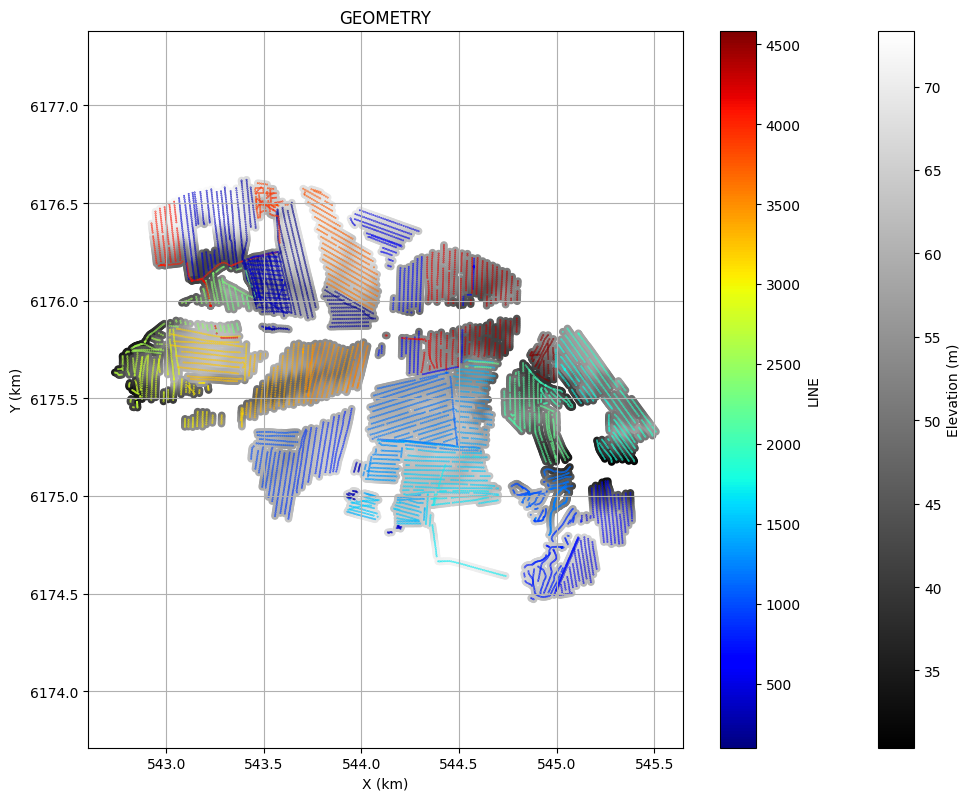

In [2]:
# For this case, we use a ready to use prior model and data set form DAUGAARD
files = ig.get_case_data(case='DAUGAARD', loadType='inout') # Load data and prior+data realizations
#files = ig.get_case_data(case='DAUGAARD', loadType='post') # # Load data and posterior realizations
#files = ig.get_case_data(case='DAUGAARD', loadAll=True) # All of the above
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)
# check that file_gex exists
if not os.path.isfile(file_gex):
    print("file_gex=%s does not exist in the current folder." % file_gex)


# make a copy using 'os' of  DAUGAARD_AVG.h5  DAUGAARD_AVG_test.h5 using the system
f_data_h5 = 'DAUGAARD_AVG_test.h5'
os.system('cp DAUGAARD_AVG.h5 %s' % (f_data_h5))

print('Using hdf5 data file %s with gex file %s' % (f_data_h5,file_gex))

fig=ig.plot_data_xy(f_data_h5)

In [3]:
# Lets first make a small copy of the large data set available
f_prior_org_h5 = 'prior_detailed_inout_N4000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5'
N_small = 50000
f_prior_h5 = ig.copy_hdf5_file(f_prior_org_h5, 'prior_test.h5',N=N_small,showInfo=3)

print("Keys in DATA")
with h5py.File(f_data_h5, 'r') as f:
    print(f.keys()) 
    
print("Keys in PRIOR")
with h5py.File(f_prior_h5, 'r') as f:
    N = f['M1'].shape[0]
    print("N=%d" % N)
    print(f.keys()) 

Trying to copy prior_detailed_inout_N4000000_dmax90_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5 to prior_test.h5
Keys in DATA
<KeysViewHDF5 ['D1', 'ELEVATION', 'LINE', 'UTMX', 'UTMY']>
Keys in PRIOR
N=50000
<KeysViewHDF5 ['D1', 'D2', 'M1', 'M2', 'M3']>


Note how 2 types of prior data are available, but only one observed data!!

## Setting up the data and prior models
At this point we have a prior with 
three data types of  MODEL parameters
M1: Resistivity
M2: Lithology
M3: Scenario category [0,1]
## We have two types of corresponding data 
D1: tTEM data
D2: Scenario category [0,1]

D2 is simply an exact copy of, as D3=I*M3, where I is the identity operator.

This means, if som information is available about the Scenario type 
this can be provided as a new 'observation'

Here is an example of how this can be done

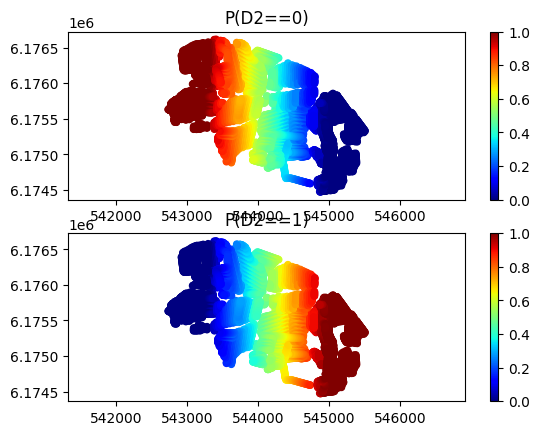

Using id=2
Trying to write D2 to DAUGAARD_AVG_test.h5
Adding group DAUGAARD_AVG_test.h5:D2 


'DAUGAARD_AVG_test.h5'

In [4]:
X, Y, LINE, ELEVATION = ig.get_geometry(f_data_h5)
Xmin = np.min(X)
Xmax = np.max(X)
Xl = Xmin + 0.2*(Xmax-Xmin)
Xr = Xmin + 0.8*(Xmax-Xmin)

P0 = .9999 # Probability of category 0
Pcat0 = np.zeros(len(X))-1
for i in range(len(X)):
    if X[i] < Xl:
        Pcat0[i] = P0
    elif X[i] > Xr:
        Pcat0[i] = 1-P0
    else:
        #Pcat0[i] = .5
        Pcat0[i] = P0+(1-2*P0)*(X[i]-Xl)/(Xr-Xl)

nclasses = 2
D_obs = np.zeros((len(X),2))
D_obs[:,0] = Pcat0
D_obs[:,1] = 1-Pcat0

plt.figure()
for ic in range(nclasses):
    plt.subplot(2,1,ic+1)
    sc = plt.scatter(X, Y, c=D_obs[:,ic], cmap='jet', vmin=0, vmax=1, s=20)
    plt.colorbar(sc)
    plt.title('P(D2==%d)'%(ic))
    plt.axis('equal')
plt.show()

# ig.write_data_gaussian(f_data_h5, D_obs, 'D2', 'Scenario    )
# Now write the 'observed data as a new data type
# If the 'id' is not set, it will be set to the next available id
ig.write_data_multinomial(D_obs, f_data_h5 = f_data_h5, showInfo=2)
# If the if is set, the data will be written to the given id, even if it allready exists
#ig.write_data_multinomial(D_obs, id=2, f_data_h5 = f_data_h5, showInfo=2)



# Ready for inversion !!

In [5]:
print("Keys in DATA")
with h5py.File(f_data_h5, 'r') as f:
    print(f.keys()) 

Keys in DATA
<KeysViewHDF5 ['D1', 'D2', 'ELEVATION', 'LINE', 'UTMX', 'UTMY']>


In [6]:
# identity copy of the prior model type for "Scenario", M3

Lets first add information directly about the scenario. 

File POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5 allready exists
Overwriting...
<--INTEGRATE_REJECTION-->
f_prior_h5=prior_test.h5
f_data_h5=DAUGAARD_AVG_test.h5
f_post_h5=POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5


All done
T_av=1.0, Time=  6.0s/11693 soundings , 0.5ms/sounding, 1953.8it/s
D1: NOT RECOGNIZED
D2: NOT RECOGNIZED
M1: CONTINUOUS
nm=90, nsounding=11693, nr=400
M_mean.shape=(11693, 90)
Creating /M1/Mean in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/Median in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/Std in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/LogMean in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5


M2: DISCRETE, N_classes =9
Creating /M2/Mode in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M2/Entropy in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M2/P


M3: DISCRETE, N_classes =2
Creating /M3/Mode in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M3/Entropy in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M3/P


Keys in POSTERIOR
<KeysViewHDF5 ['Entropy', 'Mode', 'P']>


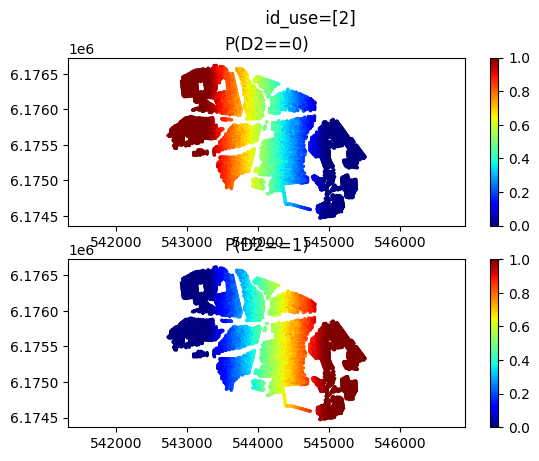

File POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5 allready exists
Overwriting...
<--INTEGRATE_REJECTION-->
f_prior_h5=prior_test.h5
f_data_h5=DAUGAARD_AVG_test.h5
f_post_h5=POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5


All done
T_av=16.6, Time= 87.0s/11693 soundings , 7.4ms/sounding, 134.4it/s
D1: NOT RECOGNIZED
D2: NOT RECOGNIZED
M1: CONTINUOUS
nm=90, nsounding=11693, nr=400
M_mean.shape=(11693, 90)
Creating /M1/Mean in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/Median in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/Std in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/LogMean in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5


M2: DISCRETE, N_classes =9
Creating /M2/Mode in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M2/Entropy in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M2/P


M3: DISCRETE, N_classes =2
Creating /M3/Mode in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M3/Entropy in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M3/P


Keys in POSTERIOR
<KeysViewHDF5 ['Entropy', 'Mode', 'P']>


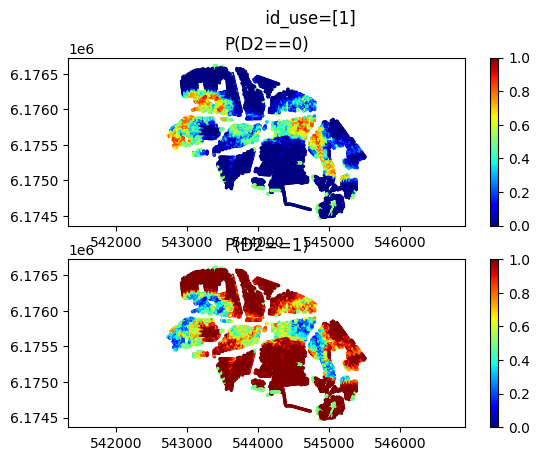

File POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5 allready exists
Overwriting...
<--INTEGRATE_REJECTION-->
f_prior_h5=prior_test.h5
f_data_h5=DAUGAARD_AVG_test.h5
f_post_h5=POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5


All done
T_av=16.7, Time= 87.6s/11693 soundings , 7.5ms/sounding, 133.5it/s
D1: NOT RECOGNIZED
D2: NOT RECOGNIZED
M1: CONTINUOUS
nm=90, nsounding=11693, nr=400
M_mean.shape=(11693, 90)
Creating /M1/Mean in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/Median in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/Std in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M1/LogMean in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5


M2: DISCRETE, N_classes =9
Creating /M2/Mode in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M2/Entropy in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M2/P


M3: DISCRETE, N_classes =2
Creating /M3/Mode in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M3/Entropy in POST_DAUGAARD_AVG_test_prior_test_Nu10000000_aT1.h5
Creating /M3/P


Keys in POSTERIOR
<KeysViewHDF5 ['Entropy', 'Mode', 'P']>


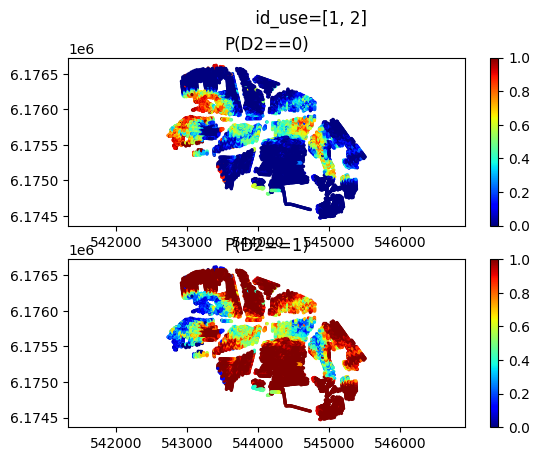

In [8]:
id_use_arr = []
id_use_arr.append([2]) # Dicrete data
id_use_arr.append([1]) # tTEM data
id_use_arr.append([1,2]) # Both discrete and tTEM data

for i in range(len(id_use_arr)):

    id_use = id_use_arr[i]
    N_use = 10000000
    updatePostStat =True
    f_post_h5 = ig.integrate_rejection(f_prior_h5, f_data_h5, 
                                    N_use = N_use, 
                                    parallel=parallel, 
                                    updatePostStat=updatePostStat, 
                                    showInfo=1,
                                    Nproc=8,
                                    id_use = id_use)

    #% 
    im=3 # Scenario Category
    with h5py.File(f_post_h5, 'r') as f:
        print("Keys in POSTERIOR")
        print(f['M3'].keys()) 
        post_MODE = f['M3/Mode'][:]
        post_P = f['M3/P'][:]
    
    P = post_P[:,:,0]

    plt.figure()
    for ic in range(nclasses):
        plt.subplot(2,1,ic+1)
        #sc = plt.scatter(X, Y, c=D_obs[:,ic], cmap='jet', vmin=0, vmax=1, s=20)
        sc = plt.scatter(X, Y, c=P[:,ic], cmap='jet', vmin=0, vmax=1, s=2)
        plt.colorbar(sc)
        plt.title('P(D2==%d)'%(ic))
        plt.axis('equal')
    plt.suptitle(' id_use=%s' % (id_use))
    plt.show()

    # ig.plot_profile(f_post_h5, im=2, i1=0, i2=1000)